In [1]:
import pandas as pd
import seaborn as sns
import eli5
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords_list = stopwords.words("english")

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews = reviews[['reviewid', 'score']]
reviews.head()

,reviewid,score
0,22703,9.3
1,22721,7.9
2,22659,7.3
3,22661,9.0
4,22725,8.1


In [3]:
reviews.shape

(18393, 2)

In [4]:
content = pd.read_csv('content.csv')
content.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [5]:
df = pd.merge(content, reviews, on='reviewid').drop('reviewid', axis=1)

In [6]:
df.isna().any()

content     True
score      False
dtype: bool

In [7]:
df = df.drop(df[df['content'].isna()].index)

In [8]:
df.head()

,content,score
0,"“Trip-hop” eventually became a ’90s punchline,...",9.3
1,"Eight years, five albums, and two EPs in, the ...",7.9
2,Minneapolis’ Uranium Club seem to revel in bei...,7.3
3,Kleenex began with a crash. It transpired one ...,9.0
4,It is impossible to consider a given release b...,8.1


In [9]:
df.shape

(18391, 2)

In [10]:
df.to_csv('content_scores.csv')

## CLASSIFICATION

In [11]:
df = pd.read_csv('content_scores.csv')

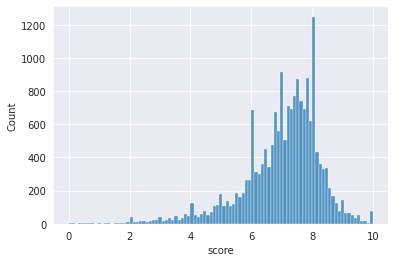

In [12]:
sns.histplot(df['score']);


In [13]:
df['score'] = df['score'].map(lambda x: 1 if x > 7 else 0)

In [14]:
values = df.score.value_counts()
values

1    10313
0     8078
Name: score, dtype: int64

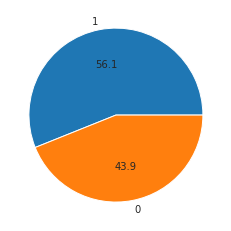

In [15]:
plt.pie(values, labels=values.keys(), autopct='%.1f');

In [16]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
                 ('logit', LogisticRegression(n_jobs=-1))])

In [17]:
%%time
pipe.fit(df['content'], df['score'])

CPU times: user 12 s, sys: 349 ms, total: 12.4 s
Wall time: 18.6 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logit', LogisticRegression(n_jobs=-1))])

In [18]:
weights = eli5.sklearn.explain_linear_classifier_weights(clf=pipe.named_steps['logit'],
                                                         vec=pipe.named_steps['tfidf'],
                                                         top=None
                                                         )

In [34]:
weights_df = eli5.formatters.as_dataframe.format_as_dataframe(weights)
weights_df = weights_df.drop(columns=['target'])
weights_df.head()

,feature,weight
0,music,3.130468
1,reissue,2.353368
2,also,2.350732
3,simple,2.269892
4,jazz,2.258806


In [39]:
weights_df.to_csv('weights.csv')

## CORPUS

In [35]:
weights_df.shape

(122363, 2)

In [36]:
weights_df.semantic = weights_df.weight.apply(lambda weight: 1 if weight > 0 else 0)

In [37]:
semantic_counts = weights_df.semantic.value_counts()
semantic_counts

1    68555
0    53808
Name: weight, dtype: int64

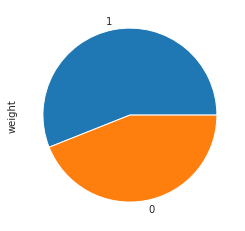

In [30]:
semantic_counts.plot(kind='pie');